In [578]:
# Cell 1: Setup and Imports
# This cell imports all necessary libraries and configures the environment.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules for model selection, preprocessing, and evaluation
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
    GridSearchCV,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.decomposition import PCA  # Used for visualizing data in reduced dimensions

import joblib  # For saving and loading models
import os  # For interacting with the operating system (e.g., creating directories)
import json  # For handling JSON data (e.g., saving experiment results)

# --- Custom Imports ---
# Make sure 'utils.py' is in the same directory as this script or in your Python path.
from utils import load_and_format_data, pick_scaler

# Configure matplotlib and seaborn for consistent plotting styles
plt.style.use('ggplot')  # Use ggplot style for plots
sns.set_palette("viridis")  # Set the color palette for seaborn plots

# List to store results from different experimental scenarios
experiment_results = []

print("Cell 1: Setup and Imports complete.")

Cell 1: Setup and Imports complete.


In [ ]:
# Cell 2: Main Configuration
# This cell defines global constants and configuration parameters for the entire workflow.

# --- Data Paths and Column Names ---
# Path to the main CSV data file
DATA_CSV_PATH = "/Users/cyriltelley/Desktop/MSE/Second_semester/PA-MReye/Codes/MREyeQC_PA/data/IQA.csv"
SAMPLE_ID_COLUMN = "sub"  # Column containing unique sample/subject IDs
FIRST_IQM_COLUMN_NAME = "centroid"  # The name of the first Image Quality Metric (IQM) column
CONTINUOUS_RATING_COLUMN = "rating"  # Column with continuous human ratings

# --- Binarization and Class Names ---
# Default threshold for binarizing continuous ratings into 'accept' or 'reject'
RATING_THRESHOLD = 1
POSITIVE_CLASS_NAME_BINARY = "accept"  # Name for the positive class (e.g., accepted images)
NEGATIVE_CLASS_NAME_BINARY = "reject"  # Name for the negative class (e.g., rejected images)

# --- Cross-Validation and Feature Selection ---
GROUP_COLUMN_FOR_CV = None  # Column to use for GroupKFold cross-validation (None if not used)
EXCLUDED_IQMS_FROM_TRAIN_X = []  # List of IQM features to explicitly exclude from training
APPLY_CORRELATION_FEATURE_SELECTION = False  # Flag to apply correlation-based feature removal (default, can be overridden by scenario)
CORRELATION_THRESHOLD = 0.9  # Threshold for removing highly correlated features

# --- Model and Training Parameters ---
SCALER_CHOICE = 'StandardScaler'  # Type of scaler to use for feature scaling
MODEL_CHOICE = 'RandomForest'  # Type of model to train (e.g., RandomForest, SVM)
TEST_SET_SIZE = 0.3  # Proportion of data to be used for the test set
RANDOM_STATE = 42  # Seed for reproducibility of random processes

# --- Output Directory ---
# Directory to save trained models and related artifacts.
# Consider updating this path if you want to save outputs to a different location.
MODEL_OUTPUT_DIR = "./trained_models_MREyeQC_PA_Scenarios_Binary_Updated"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)  # Create the directory if it doesn't exist

print("Cell 2: Main Configuration complete.")

Cell 2: Main Configuration complete.


In [580]:
# Cell 3: Scenario Definition and Application
# This cell defines a specific experimental scenario and applies its settings,
# allowing for easy switching between different configurations.

# --- Define Scenario Name ---
scenario_name = "Scenrario 2 THRESHOLD = 1.0"

# --- Scenario-Specific Parameters ---
# The threshold for binarizing continuous ratings for this specific scenario.
CURRENT_RATING_THRESHOLD = 1.0

# Optional: List of subject IDs to include in the analysis.
# Set to `None` to include all subjects.
SUBJECT_ID_FILTER_LIST = None
# SUBJECT_ID_FILTER_LIST = list(range(1, 84)) # Example: to include subjects 1 to 83

# Cross-validation strategy for this scenario ("KFold" or "StratifiedKFold").
CV_STRATEGY_FOR_SCENARIO = "KFold"
# CV_STRATEGY_FOR_SCENARIO = "StratifiedKFold"

# Flag to enable or disable correlation-based feature removal for this scenario.
APPLY_CORRELATION_FEATURE_SELECTION = True

# --- Apply Scenario Settings to Global Variables ---
RATING_THRESHOLD = CURRENT_RATING_THRESHOLD # Override global threshold with scenario-specific one

# --- Print Scenario Summary ---
print(f"--- RUNNING SCENARIO: {scenario_name} ---")
print(f"   Current Rating Threshold: {RATING_THRESHOLD}")
print(f"   Subject ID Filter: {'All Subjects' if SUBJECT_ID_FILTER_LIST is None else f'Subset of {len(SUBJECT_ID_FILTER_LIST)} subjects (e.g., {SUBJECT_ID_FILTER_LIST[:3]}...)'}")
print(f"   CV Strategy: {CV_STRATEGY_FOR_SCENARIO}")
print(f"   Apply Correlation Feature Selection: {APPLY_CORRELATION_FEATURE_SELECTION}")

--- RUNNING SCENARIO: Scenrario 2 THRESHOLD = 1.0 ---
   Current Rating Threshold: 1.0
   Subject ID Filter: All Subjects
   CV Strategy: KFold
   Apply Correlation Feature Selection: True


Removed 1 rows due to NaN values in IQM features.

--- Debugging Subject IDs ---
First 5 unique values in 'sub': [1 2 3 4 5]
Data type of 'sub': int64
First 5 values in your SUBJECT_ID_FILTER_LIST: None
--- End Debugging Subject IDs ---

Cell 3 (now 4): Load and Filter Data complete.
   df_scenario_data shape for 'Scenrario 2 THRESHOLD = 1.0': (167, 193)


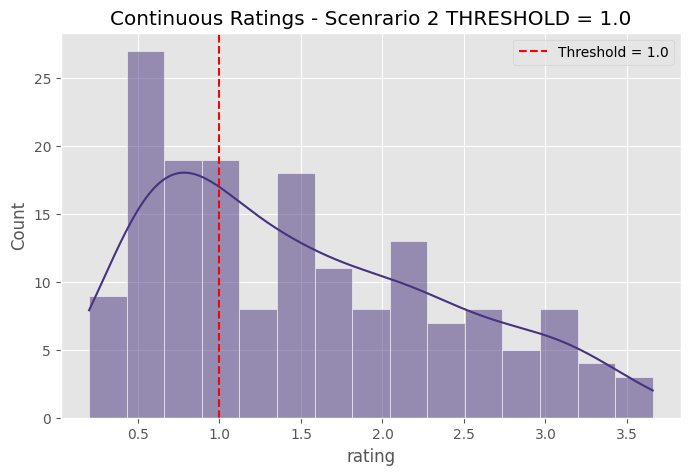

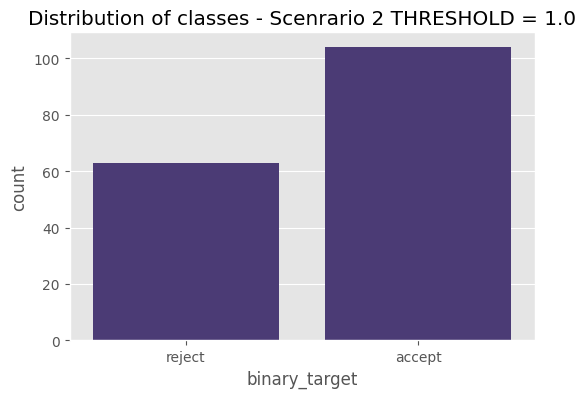


--- Correlation Matrix of All Candidate IQM Features (185 features) ---


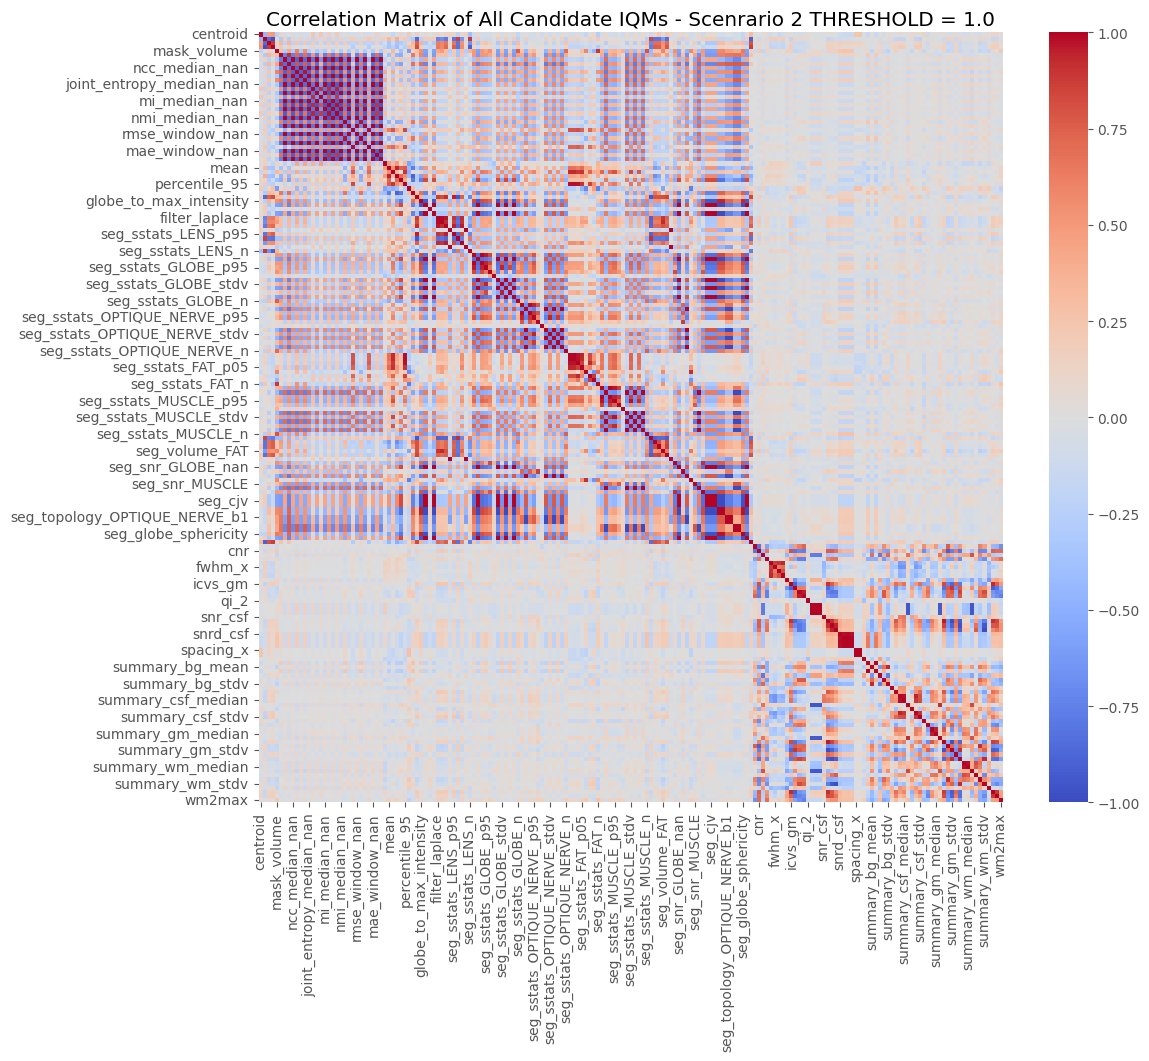

Initial number of features before any selection: 185

Applying correlation-based feature selection for Scenrario 2 THRESHOLD = 1.0 (Threshold: 0.9)...
   Features to drop due to high correlation: ['seg_sstats_OPTIQUE_NERVE_median', 'icvs_gm', 'summary_csf_p95', 'icvs_wm', 'seg_sstats_MUSCLE_mad_nan', 'joint_entropy_window_nan', 'seg_globe_sphericity', 'seg_sstats_GLOBE_k_nan', 'mi_window', 'seg_sstats_LENS_median', 'seg_sstats_OPTIQUE_NERVE_stdv_nan', 'seg_sstats_MUSCLE_stdv_nan', 'seg_topology_GLOBE_b1', 'nmi_window', 'seg_sstats_OPTIQUE_NERVE_mad_nan', 'rpve_csf', 'snrd_csf', 'rpve_wm', 'seg_sstats_GLOBE_mad_nan', 'nmae_window_nan', 'ncc_window', 'summary_wm_mad', 'ncc_median_nan', 'centroid_nan', 'seg_topology_OPTIQUE_NERVE_b1', 'rmse_window_nan', 'snrd_gm', 'seg_sstats_LENS_mean', 'mi_window_nan', 'nrmse_window', 'std', 'seg_sstats_GLOBE_median', 'seg_sstats_OPTIQUE_NERVE_mean', 'seg_sstats_MUSCLE_mean_nan', 'spacing_x', 'snr_wm', 'seg_sstats_LENS_mad', 'snr_total', 'seg_cjv', 'nmi

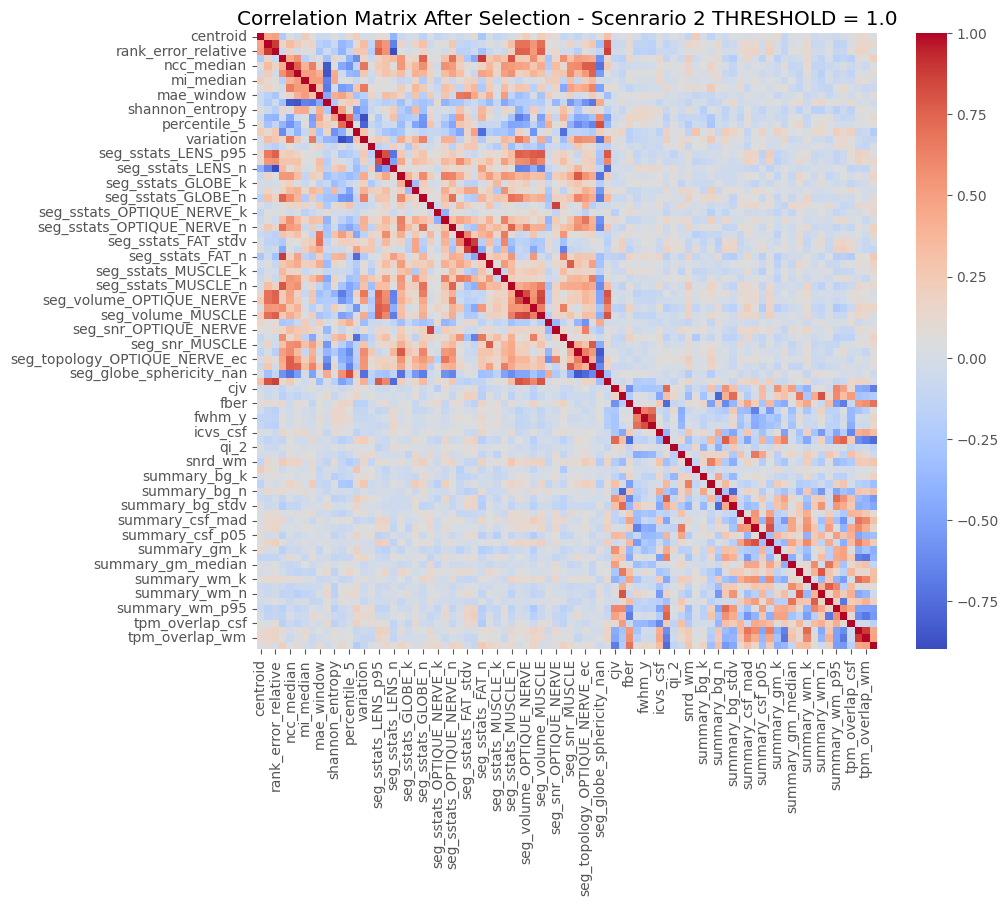

Cell 4: Preprocessing for Scenrario 2 THRESHOLD = 1.0 complete.


In [581]:
# Cell 4: Data Loading, Filtering, and Preprocessing
# This cell handles loading the raw data, filtering it based on the defined scenario,
# binarizing the target variable, performing feature selection, and scaling the features.

# Initialize empty DataFrames to store processed data
df_processed_data_full = pd.DataFrame()
features_df = pd.DataFrame()
metadata_df = pd.DataFrame()
df_scenario_data = pd.DataFrame()

# Load and format the data using the custom utility function
features_df, metadata_df = load_and_format_data(DATA_CSV_PATH, FIRST_IQM_COLUMN_NAME)

# Concatenate features and metadata if both are successfully loaded and have consistent lengths
if not features_df.empty and not metadata_df.empty and len(features_df) == len(metadata_df):
    df_processed_data_full = pd.concat([metadata_df, features_df], axis=1)

# --- Debugging Subject IDs (Optional) ---
# This block helps verify that subject IDs are correctly loaded and filtered.
if not df_processed_data_full.empty and SAMPLE_ID_COLUMN in df_processed_data_full.columns:
    print(f"\n--- Debugging Subject IDs ---")
    print(f"First 5 unique values in '{SAMPLE_ID_COLUMN}': {df_processed_data_full[SAMPLE_ID_COLUMN].unique()[:5]}")
    print(f"Data type of '{SAMPLE_ID_COLUMN}': {df_processed_data_full[SAMPLE_ID_COLUMN].dtype}")
    print(f"First 5 values in your SUBJECT_ID_FILTER_LIST: {SUBJECT_ID_FILTER_LIST[:5] if SUBJECT_ID_FILTER_LIST else 'None'}")
    if SUBJECT_ID_FILTER_LIST:
        print(f"Data type of elements in SUBJECT_ID_FILTER_LIST (first element): {type(SUBJECT_ID_FILTER_LIST[0])}")
    print(f"--- End Debugging Subject IDs ---\n")

# --- Apply Subject ID Filtering ---
if not df_processed_data_full.empty:
    if SUBJECT_ID_FILTER_LIST is not None and SAMPLE_ID_COLUMN in df_processed_data_full.columns:
        # Filter data based on the specified subject IDs for the current scenario
        df_scenario_data = df_processed_data_full[
            df_processed_data_full[SAMPLE_ID_COLUMN].isin(SUBJECT_ID_FILTER_LIST)
        ].copy()
    else:
        # If no subject filter is specified, use all processed data
        df_scenario_data = df_processed_data_full.copy()

    # --- Prepare Target Variable (Binarization) ---
    if not df_scenario_data.empty:
        # Convert continuous ratings to numeric, coercing errors to NaN
        df_scenario_data[CONTINUOUS_RATING_COLUMN] = pd.to_numeric(
            df_scenario_data[CONTINUOUS_RATING_COLUMN], errors='coerce'
        )
        # Drop rows where the continuous rating is NaN
        df_scenario_data.dropna(subset=[CONTINUOUS_RATING_COLUMN], inplace=True)

print("Cell 3 (now 4): Load and Filter Data complete.")
print(f"   df_scenario_data shape for '{scenario_name}': {df_scenario_data.shape}")


# Re-initialize variables for data preprocessing, ensuring clean state for each run
X_train, X_test = pd.DataFrame(), pd.DataFrame()
y_train, y_test = None, None
X_train_scaled, X_test_scaled = None, None
numeric_features_final = []  # Will store the list of features used for training
scaler_obj = None
y = None  # Binary target variable

if not df_scenario_data.empty and CONTINUOUS_RATING_COLUMN in df_scenario_data.columns:
    # --- Visualize Continuous Ratings Distribution ---
    plt.figure(figsize=(8, 5))
    sns.histplot(df_scenario_data[CONTINUOUS_RATING_COLUMN], kde=True, bins=15)
    plt.title(f'Continuous Ratings - {scenario_name}')
    if RATING_THRESHOLD is not None:
        plt.axvline(RATING_THRESHOLD, color='r', linestyle='--', label=f'Threshold = {RATING_THRESHOLD}')
        plt.legend()
    plt.show()

    # --- Binarize Continuous Ratings ---
    # Create a new binary target column based on the RATING_THRESHOLD
    df_scenario_data['binary_target'] = df_scenario_data[CONTINUOUS_RATING_COLUMN].apply(
        lambda x: 1 if x >= RATING_THRESHOLD else 0
    )
    y = df_scenario_data['binary_target'].copy() # Assign binary target to 'y'

    # --- Visualize Binary Class Distribution ---
    plt.figure(figsize=(6, 4))
    sns.countplot(x='binary_target', data=df_scenario_data)
    plt.title(f'Distribution of classes - {scenario_name}')
    plt.xticks([0, 1], [NEGATIVE_CLASS_NAME_BINARY, POSITIVE_CLASS_NAME_BINARY])
    plt.show()

    # --- Prepare Candidate Features (IQMs) ---
    # Identify IQM columns present in the scenario data
    existing_feature_cols = [col for col in features_df.columns if col in df_scenario_data.columns]
    X_candidate_features = df_scenario_data[existing_feature_cols].copy()

    if not X_candidate_features.empty:
        # --- Visualize Correlation Matrix of All Candidate Features ---
        print(f"\n--- Correlation Matrix of All Candidate IQM Features ({X_candidate_features.shape[1]} features) ---")
        corr_matrix_all = X_candidate_features.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix_all, annot=False, cmap='coolwarm', fmt=".1f") # annot=False for large matrices
        plt.title(f'Correlation Matrix of All Candidate IQMs - {scenario_name}')
        plt.show()

        # X initially includes all candidate features, potentially excluding some predefined ones
        X = X_candidate_features.drop(columns=EXCLUDED_IQMS_FROM_TRAIN_X, errors='ignore') if EXCLUDED_IQMS_FROM_TRAIN_X else X_candidate_features.copy()
        print(f"Initial number of features before any selection: {X.shape[1]}")

        # --- Apply Correlation-based Feature Selection (if enabled) ---
        if APPLY_CORRELATION_FEATURE_SELECTION:
            print(f"\nApplying correlation-based feature selection for {scenario_name} (Threshold: {CORRELATION_THRESHOLD})...")
            corr_matrix_X = X.corr().abs() # Calculate absolute correlation matrix

            # Select upper triangle of correlation matrix to avoid duplicates
            upper = corr_matrix_X.where(np.triu(np.ones(corr_matrix_X.shape), k=1).astype(bool))

            # Find features with correlation greater than the threshold
            to_drop = set()
            for column in upper.columns:
                if column not in to_drop: # Check if column already marked to be dropped
                    correlated_features = upper[upper[column] > CORRELATION_THRESHOLD].index
                    for feature in correlated_features:
                         if feature not in to_drop: # Ensure the other feature in the pair isn't already dropped
                            to_drop.add(feature) # Add one feature from the pair to the drop set

            print(f"   Features to drop due to high correlation: {list(to_drop)}")
            X = X.drop(columns=list(to_drop), errors='ignore') # Drop the identified features
            print(f"   Number of features after correlation-based selection: {X.shape[1]}")

            if not X.empty:
                # --- Visualize Correlation Matrix After Feature Selection ---
                print(f"\n--- Correlation Matrix After Feature Selection ({X.shape[1]} features) ---")
                corr_matrix_selected = X.corr()
                plt.figure(figsize=(10, 8))
                sns.heatmap(corr_matrix_selected, annot=False, cmap='coolwarm', fmt=".1f")
                plt.title(f'Correlation Matrix After Selection - {scenario_name}')
                plt.show()
            else:
                print("   WARNING: All features dropped after correlation selection. Check threshold or data.")

        # Store the final list of numeric features used for training
        numeric_features_final = X.columns.tolist()

        if not X.empty:
            X.fillna(0, inplace=True) # Impute NaN values with 0 (consider more sophisticated methods if appropriate)

            # --- Split Data into Training and Test Sets ---
            # Stratify by 'y' to ensure balanced class distribution in both sets
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE, stratify=y
            )

            # --- Feature Scaling ---
            scaler_obj = pick_scaler(SCALER_CHOICE) # Get the chosen scaler object
            if scaler_obj is not None:
                # Fit scaler on training data and transform both training and test data
                X_train_scaled_np = scaler_obj.fit_transform(X_train)
                X_test_scaled_np = scaler_obj.transform(X_test)
            else:
                # If no scaler is picked, use the data as is (as numpy arrays)
                X_train_scaled_np = X_train.copy().values
                X_test_scaled_np = X_test.copy().values

            # Convert scaled numpy arrays back to DataFrames with original column names and indices
            X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=numeric_features_final, index=X_train.index)
            X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=numeric_features_final, index=X_test.index)
        else:
            print(f"   WARNING: X is empty after feature selection for {scenario_name}. Model training will be skipped.")
            X_train_scaled = pd.DataFrame() # Ensure it's an empty DataFrame to prevent errors
            X_test_scaled = pd.DataFrame() # Ensure it's an empty DataFrame

print(f"Cell 4: Preprocessing for {scenario_name} complete.")
if X_train_scaled is None or X_train_scaled.empty: # Check if None or empty
    print(f"   WARNING: X_train_scaled is empty or None for {scenario_name}. Model training will be skipped.")

In [582]:
# Cell 5: Model Training
# This cell sets up the cross-validation strategy, defines the model and its hyperparameters,
# and performs hyperparameter tuning using GridSearchCV.

best_model = None  # Initialize the best trained model
grid_search = None # Initialize the GridSearchCV object

# Proceed with model training only if scaled training data and target are available
if X_train_scaled is not None and y_train is not None and not X_train_scaled.empty:
    fit_params_for_gridsearch = {} # Parameters to pass to the estimator's fit method (if any)

    # --- Define Cross-Validation Splitter ---
    if CV_STRATEGY_FOR_SCENARIO == "StratifiedKFold":
        # StratifiedKFold maintains the same proportion of class labels in each fold as in the full dataset.
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    elif CV_STRATEGY_FOR_SCENARIO == "KFold":
        # KFold shuffles and splits the data into k folds without considering class distribution.
        cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    # elif CV_STRATEGY_FOR_SCENARIO == "GroupKFold" and GROUP_COLUMN_FOR_CV and GROUP_COLUMN_FOR_CV in df_scenario_data.columns:
    #    # Uncomment and implement if GroupKFold is needed.
    #    # GroupKFold ensures that the same group (e.g., subject) does not appear in both train and test sets.
    #    from sklearn.model_selection import GroupKFold
    #    groups = df_scenario_data.loc[X_train_scaled.index, GROUP_COLUMN_FOR_CV] # Ensure groups align with X_train_scaled
    #    cv_splitter = GroupKFold(n_splits=5)
    #    fit_params_for_gridsearch['groups'] = groups # Pass groups to GridSearchCV fit method
    else: # Default fallback if the specified strategy is not recognized or configured
        print(f"Warning: CV_STRATEGY_FOR_SCENARIO '{CV_STRATEGY_FOR_SCENARIO}' not fully matched. Defaulting to StratifiedKFold.")
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    print(f"Using CV Splitter for {scenario_name}: {type(cv_splitter).__name__}")

    model_instance = None # Initialize the model instance
    param_grid = {}       # Initialize the hyperparameter grid

    # --- Model Selection and Hyperparameter Grid Definition ---
    if MODEL_CHOICE == 'RandomForest':
        # RandomForestClassifier: an ensemble learning method for classification.
        # 'class_weight='balanced'' automatically adjusts weights inversely proportional to class frequencies.
        model_instance = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
        param_grid = {
            'n_estimators': [50, 100, 200],      # Number of trees in the forest
            'max_depth': [None, 10, 20],        # Maximum depth of the tree (None means unlimited)
            'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required to be at a leaf node
        }
    elif MODEL_CHOICE == 'SVM':
        # Support Vector Machine (SVC) for classification.
        # 'probability=True' enables probability estimates.
        from sklearn.svm import SVC # Import SVC only if chosen
        model_instance = SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced')
        param_grid = {
            'C': [0.1, 1, 10],                  # Regularization parameter
            'gamma': ['scale', 'auto'],         # Kernel coefficient ('scale' uses 1 / (n_features * X.var()))
            'kernel': ['rbf']                   # Kernel type ('rbf' for Radial Basis Function)
        }
    else:
        print(f"ERROR: MODEL_CHOICE '{MODEL_CHOICE}' is not configured in Cell 5's model definitions.")

    # --- Perform GridSearchCV ---
    if model_instance is not None and param_grid:
        # GridSearchCV exhaustively searches over specified parameter values for an estimator.
        # 'scoring='roc_auc'' uses ROC AUC as the metric to evaluate models.
        # 'n_jobs=-1' uses all available CPU cores.
        grid_search = GridSearchCV(estimator=model_instance, param_grid=param_grid,
                                   cv=cv_splitter, scoring='roc_auc',
                                   n_jobs=-1, verbose=0)

        # Fit GridSearchCV to the scaled training data
        grid_search.fit(X_train_scaled, y_train, **fit_params_for_gridsearch)
        best_model = grid_search.best_estimator_ # The best estimator found by GridSearchCV
    else:
        print(f"Model instance or param_grid not set for {MODEL_CHOICE}. Skipping GridSearchCV.")

print(f"Cell 5: Model Training for {scenario_name} complete.")
if best_model is not None and grid_search is not None:
    print(f"   Best model parameters: {grid_search.best_params_}")
    print(f"   Best CV ROC AUC score: {grid_search.best_score_:.4f}")
else:
    print(f"   WARNING: Model training skipped or failed for {scenario_name}. 'best_model' is None.")

Using CV Splitter for Scenrario 2 THRESHOLD = 1.0: KFold
Cell 5: Model Training for Scenrario 2 THRESHOLD = 1.0 complete.
   Best model parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
   Best CV ROC AUC score: 0.8952



--- Evaluation Metrics (Scenrario 2 THRESHOLD = 1.0) ---
Agreement (Correct/Incorrect):   36/15 (70.6%)
Overall Accuracy:                0.7059
Balanced Accuracy:               0.6373
ROC AUC:                         0.7089
F1-Score:                        0.7945
Precision:                       0.7073
Recall:                          0.9062

Classification Report:
              precision    recall  f1-score   support

      reject       0.70      0.37      0.48        19
      accept       0.71      0.91      0.79        32

    accuracy                           0.71        51
   macro avg       0.70      0.64      0.64        51
weighted avg       0.70      0.71      0.68        51



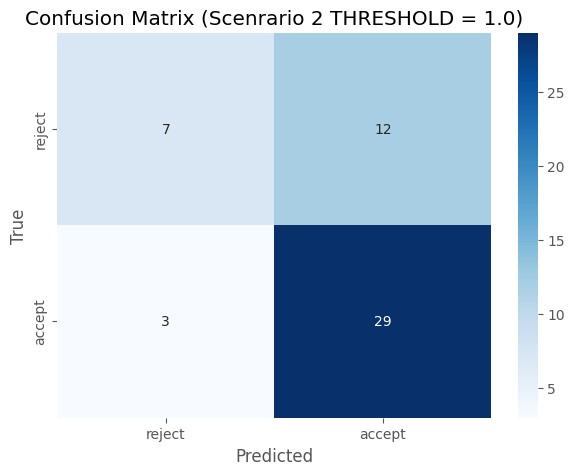

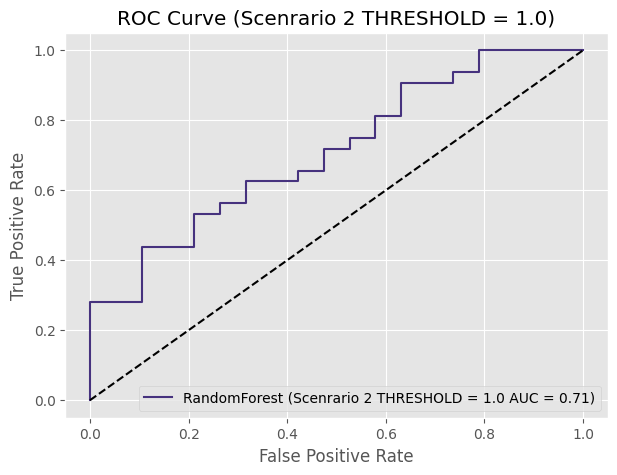


--- PCA Visualization of Test Set Predictions ---


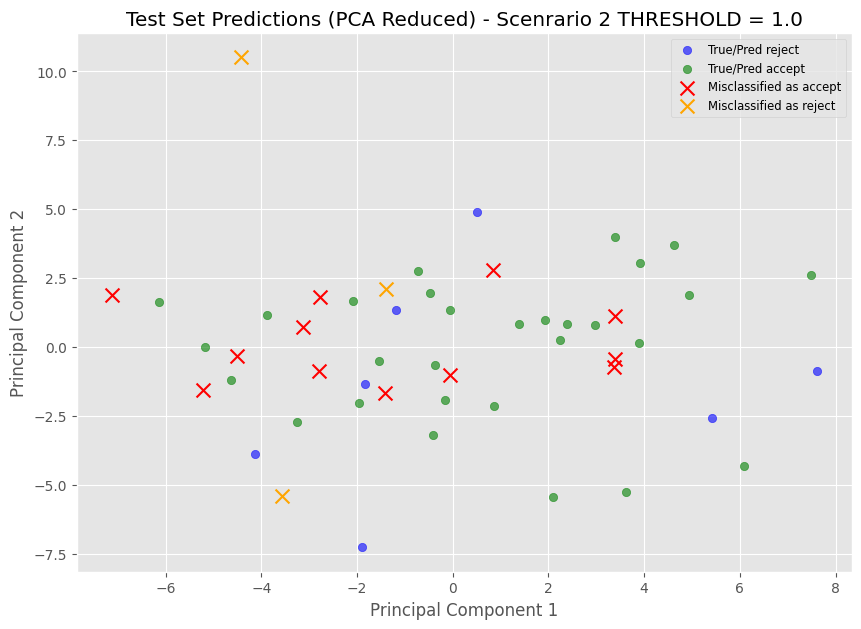

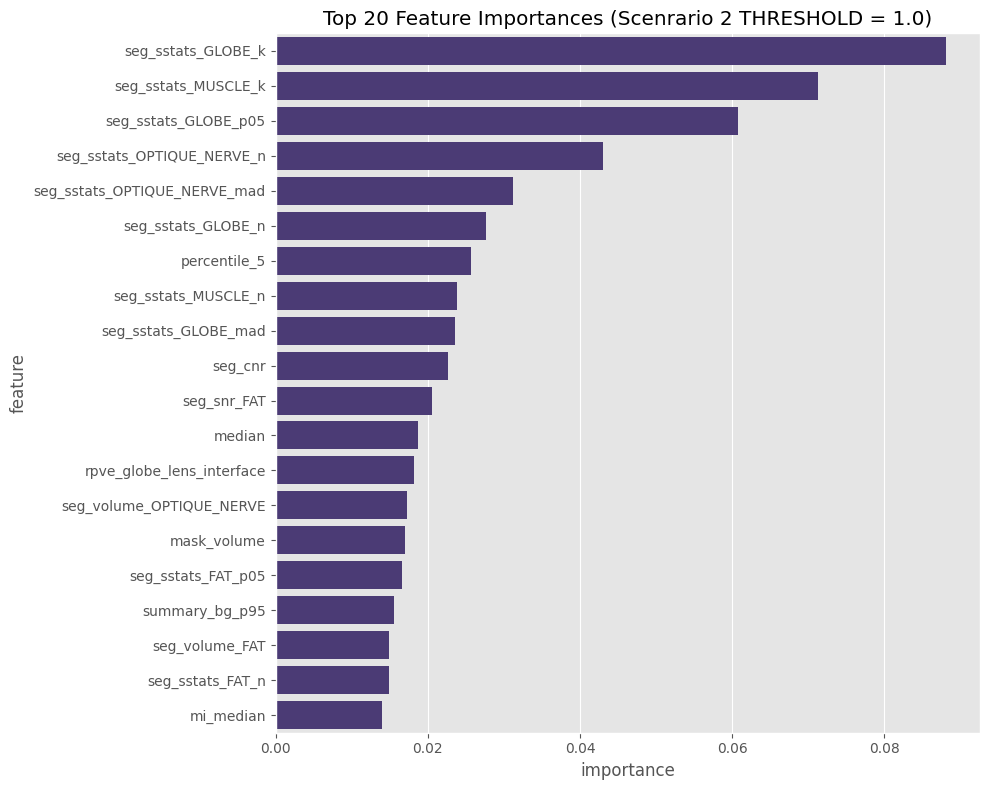

Cell 6: Evaluation for Scenrario 2 THRESHOLD = 1.0 complete.


In [583]:
# Cell 6: Model Prediction and Evaluation
# This cell evaluates the performance of the best trained model on the unseen test set,
# calculates various metrics, and generates informative visualizations.

# Proceed with evaluation only if a best model exists and test data is available
if best_model and X_test_scaled is not None and y_test is not None and not X_test_scaled.empty:
    # --- Make Predictions ---
    y_pred_test = best_model.predict(X_test_scaled) # Predict class labels
    roc_auc = float('nan') # Initialize ROC AUC to NaN
    y_pred_proba_test = None

    # Try to get probability predictions for ROC AUC calculation if the model supports it
    if hasattr(best_model, 'predict_proba'):
        try:
            y_pred_proba_test = best_model.predict_proba(X_test_scaled)[:, 1] # Probability of the positive class
            roc_auc = roc_auc_score(y_test, y_pred_proba_test)
        except Exception as e:
            print(f"Could not calculate predict_proba or ROC AUC: {e}")
            pass # Continue even if ROC AUC calculation fails

    # --- Calculate Standard Classification Metrics ---
    accuracy = accuracy_score(y_test, y_pred_test)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, pos_label=1, zero_division=0) # F1-score for the positive class
    precision_val = precision_score(y_test, y_pred_test, pos_label=1, zero_division=0) # Precision for the positive class
    recall_val = recall_score(y_test, y_pred_test, pos_label=1, zero_division=0) # Recall for the positive class

    # --- Calculate Agreement Counts ---
    total_samples = len(y_test)
    # Ensure y_test is a numpy array for direct comparison if it's a pandas Series
    agreement_count = np.sum(y_test.values == y_pred_test) # Number of correctly classified samples
    disagreement_count = total_samples - agreement_count # Number of incorrectly classified samples

    # Store current run's metrics in a dictionary
    current_run_metrics = {
        'Scenario': scenario_name,
        'Num_Features': len(numeric_features_final) if numeric_features_final else X_test_scaled.shape[1],
        'ROC_AUC': roc_auc,
        'Accuracy': accuracy,
        'Balanced_Accuracy': balanced_acc,
        'F1_Score': f1,
        'Precision': precision_val,
        'Recall': recall_val
    }
    experiment_results.append(current_run_metrics) # Add to the list of all experiment results

    # --- Print Evaluation Metrics ---
    print(f"\n--- Evaluation Metrics ({scenario_name}) ---")
    print(f"Agreement (Correct/Incorrect):   {agreement_count}/{disagreement_count} ({accuracy:.1%})")
    print(f"Overall Accuracy:                {accuracy:.4f}")
    print(f"Balanced Accuracy:               {balanced_acc:.4f}")
    print(f"ROC AUC:                         {roc_auc:.4f}")
    print(f"F1-Score:                        {f1:.4f}")
    print(f"Precision:                       {precision_val:.4f}")
    print(f"Recall:                          {recall_val:.4f}")

    report_target_names = [NEGATIVE_CLASS_NAME_BINARY, POSITIVE_CLASS_NAME_BINARY]
    print("\nClassification Report:")
    # Provides a text summary of the precision, recall, F1-score and support for each class
    print(classification_report(y_test, y_pred_test, target_names=report_target_names, zero_division=0))

    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(7, 5))
    # Heatmap visualizes the confusion matrix, showing true vs. predicted counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=report_target_names, yticklabels=report_target_names)
    plt.title(f'Confusion Matrix ({scenario_name})')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

    # --- Plot ROC Curve ---
    if y_pred_proba_test is not None and not np.isnan(roc_auc):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test, pos_label=1) # Calculate ROC curve points
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f'{MODEL_CHOICE} ({scenario_name} AUC = {roc_auc:.2f})') # Plot ROC curve
        plt.plot([0, 1], [0, 1], 'k--') # Plot the diagonal random classifier line
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve ({scenario_name})')
        plt.legend(loc="lower right"); plt.grid(True)
        plt.show()

    # --- PCA Visualization of Test Set Predictions ---
    # Visualizes test data points in a 2D PCA space, colored by true and predicted labels.
    if not X_test_scaled.empty and y_test is not None and y_pred_test is not None:
        from sklearn.decomposition import PCA # Ensure PCA is imported for this section
        print("\n--- PCA Visualization of Test Set Predictions ---")
        pca = PCA(n_components=2, random_state=RANDOM_STATE) # Initialize PCA to 2 components
        X_test_pca = pca.fit_transform(X_test_scaled) # Apply PCA to the scaled test data

        plt.figure(figsize=(10, 7))
        # Correctly classified samples
        plt.scatter(X_test_pca[(y_test == 0) & (y_pred_test == 0), 0], X_test_pca[(y_test == 0) & (y_pred_test == 0), 1], label=f'True/Pred {NEGATIVE_CLASS_NAME_BINARY}', c='blue', marker='o', alpha=0.6)
        plt.scatter(X_test_pca[(y_test == 1) & (y_pred_test == 1), 0], X_test_pca[(y_test == 1) & (y_pred_test == 1), 1], label=f'True/Pred {POSITIVE_CLASS_NAME_BINARY}', c='green', marker='o', alpha=0.6)
        # Misclassified samples
        plt.scatter(X_test_pca[(y_test == 0) & (y_pred_test == 1), 0], X_test_pca[(y_test == 0) & (y_pred_test == 1), 1], label=f'Misclassified as {POSITIVE_CLASS_NAME_BINARY}', c='red', marker='x', s=100)
        plt.scatter(X_test_pca[(y_test == 1) & (y_pred_test == 0), 0], X_test_pca[(y_test == 1) & (y_pred_test == 0), 1], label=f'Misclassified as {NEGATIVE_CLASS_NAME_BINARY}', c='orange', marker='x', s=100)

        plt.title(f'Test Set Predictions (PCA Reduced) - {scenario_name}')
        plt.xlabel('Principal Component 1'); plt.ylabel('Principal Component 2')
        plt.legend(loc='best', fontsize='small'); plt.grid(True)
        plt.show()

    # --- Feature Importances (for models that support it, e.g., RandomForest) ---
    if hasattr(best_model, 'feature_importances_') and numeric_features_final:
        # Check if the number of importances matches the number of features
        if len(numeric_features_final) == len(best_model.feature_importances_):
            importances = best_model.feature_importances_
            # Create a DataFrame for easy sorting and plotting
            ft_imp_df = pd.DataFrame({'feature': numeric_features_final, 'importance': importances})
            ft_imp_df = ft_imp_df.sort_values(by='importance', ascending=False) # Sort by importance

            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='feature', data=ft_imp_df.head(20)) # Plot top 20 features
            plt.title(f'Top 20 Feature Importances ({scenario_name})')
            plt.tight_layout(); plt.show()
        else:
            print("   WARNING: Mismatch between number of features and feature importances. Cannot plot.")
    elif not hasattr(best_model, 'feature_importances_'):
        print(f"   NOTE: Model '{MODEL_CHOICE}' does not have 'feature_importances_' attribute.")

print(f"Cell 6: Evaluation for {scenario_name} complete.")

In [592]:

# Cell 7: Saving the Model
if best_model and numeric_features_final is not None and os.path.exists(MODEL_OUTPUT_DIR):
    safe_scenario_name_suffix = "_" + "".join(c if c.isalnum() else "_" for c in scenario_name)
        
    model_filename = os.path.join(MODEL_OUTPUT_DIR, f"model{safe_scenario_name_suffix}.joblib")
    joblib.dump(best_model, model_filename)

    if scaler_obj:
        scaler_filename = os.path.join(MODEL_OUTPUT_DIR, f"scaler{safe_scenario_name_suffix}.joblib")
        joblib.dump(scaler_obj, scaler_filename)
    
    features_filename = os.path.join(MODEL_OUTPUT_DIR, f"features{safe_scenario_name_suffix}.json")
    with open(features_filename, 'w') as f: json.dump(numeric_features_final, f)
    
    best_cv_score = grid_search.best_score_ if grid_search is not None else 'N/A'

    config_to_save = {
        "SCENARIO_NAME": scenario_name, "RATING_THRESHOLD": RATING_THRESHOLD,
        "CV_STRATEGY_FOR_SCENARIO": CV_STRATEGY_FOR_SCENARIO,
        "MODEL_CHOICE": MODEL_CHOICE, 
        "BEST_MODEL_PARAMS": best_model.get_params(),
        "APPLY_CORRELATION_FEATURE_SELECTION": APPLY_CORRELATION_FEATURE_SELECTION,
        "CORRELATION_THRESHOLD_USED": CORRELATION_THRESHOLD if APPLY_CORRELATION_FEATURE_SELECTION else "N/A",
        "BEST_CV_SCORE (ROC_AUC)": best_cv_score
    }
    config_filename = os.path.join(MODEL_OUTPUT_DIR, f"config{safe_scenario_name_suffix}.json")
    with open(config_filename, 'w') as f: json.dump(config_to_save, f, indent=2)

print(f"Cell 7: Saving Model for {scenario_name} complete.")



Cell 7: Saving Model for scenario 1 complete.
